In [1]:
import os
import json
import random

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import collections  as mc
from sklearn.cluster import KMeans
from keras.models import Sequential
from keras import layers

random.seed(1337)
np.random.seed(451)

Using TensorFlow backend.


In [2]:
def data_from_file(file):
    # Read json sequence data
    with open(file) as f:
        data = np.array(json.load(f))
    return data

In [3]:
# Hyperparameters
# ======================================================================
num_classes = 100        # Amount of k-means clusters & classes for NN
batch_size = 32          # How many samples are in a batch
seq_len = 3              # How long is the sequence / sample to train
data_split = 0.1         # Percentage for validation & testing set

num_layers = 0           # Number of hidden LSTM layers
num_units = 32           # Number of units per LSTM layer
epochs = 50              # How many epochs to train
dropout = 0.2            # Dropout after every layer

# Data sources
# ======================================================================
# data = data_from_file('./files/json/sequence.json')
# data = data_from_file('./files/json/sequence2.json')
data = data_from_file('./files/json/sequence6.json')

In [4]:
def k_means_encode_data(data, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(data[:,0])
    new_data = []
    for column in data:
        new_column = []
        for point in column:
            predicted = kmeans.predict([point])[0]
            new_column.append(predicted)
        new_data.append(new_column)
    return np.array(new_data), kmeans

def k_means_decode_data(data, kmeans):
    new_data = []
    for column in data:
        new_column = []
        for cluster_index in column:
            center = kmeans.cluster_centers_[cluster_index]
            new_column.append(center)
        new_data.append(new_column)
    return np.array(new_data)

# Simplify the PCA space with k-means clustering
encoded_data, kmeans = k_means_encode_data(data, num_classes)
decoded_data_test = k_means_decode_data(encoded_data, kmeans)
print('Number of classes:', num_classes)
print('Data size:', len(data))

Number of classes: 100
Data size: 1772


In [5]:
# Show an example on how the data looks now
test_index = 0
print('Original:', data[test_index])
print('Encoded:', encoded_data[test_index])
print('Decoded:', decoded_data_test[test_index])

Original: [[0.04464543 0.59780048]
 [0.05198301 0.52077091]]
Encoded: [65 66]
Decoded: [[0.03775168 0.59461032]
 [0.04427884 0.51254395]]


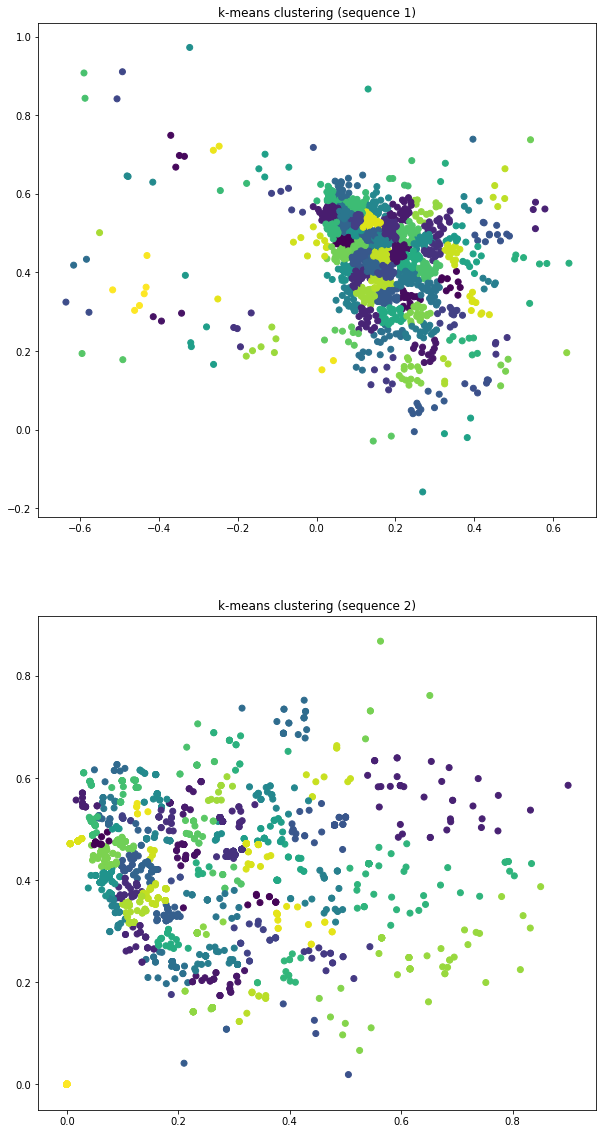

In [6]:
# Plot kmeans clusters
plt.figure(figsize=(10, 20))

plt.subplot(2, 1, 1, title="k-means clustering (sequence 1)")
plt.scatter(data[:, 0, 0],
           data[:, 0, 1],
           c=kmeans.predict(data[:, 0]))

plt.subplot(2, 1, 2, title="k-means clustering (sequence 2)")
plt.scatter(data[:, 1, 0],
           data[:, 1, 1],
           c=kmeans.predict(data[:, 1]))

plt.show()

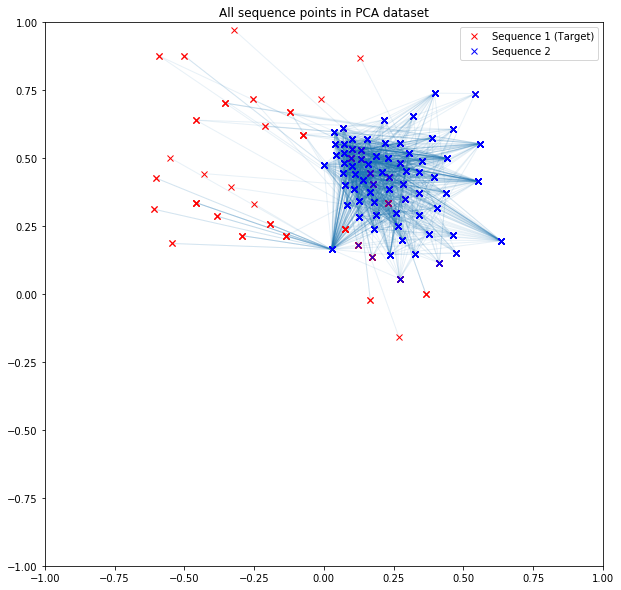

[[65 66]
 [68 76]
 [30 76]
 ...
 [90 27]
 [22 27]
 [13 80]]


In [7]:
# Plot PCA coordinate data
plot_data = decoded_data_test

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_title('All sequence points in PCA dataset')
ax.axis([-1.0, 1.0, -1.0, 1.0])

ax.plot(plot_data[:,0,0], plot_data[:,0,1], 'rx', label='Sequence 1 (Target)')
ax.plot(plot_data[:,1,0], plot_data[:,1,1], 'bx', label='Sequence 2')

lines = [[p[0], p[1]] for p in plot_data]
lc = mc.LineCollection(lines, linewidths=1, alpha=0.1)
ax.add_collection(lc)

ax.legend()
plt.show()

print(encoded_data)

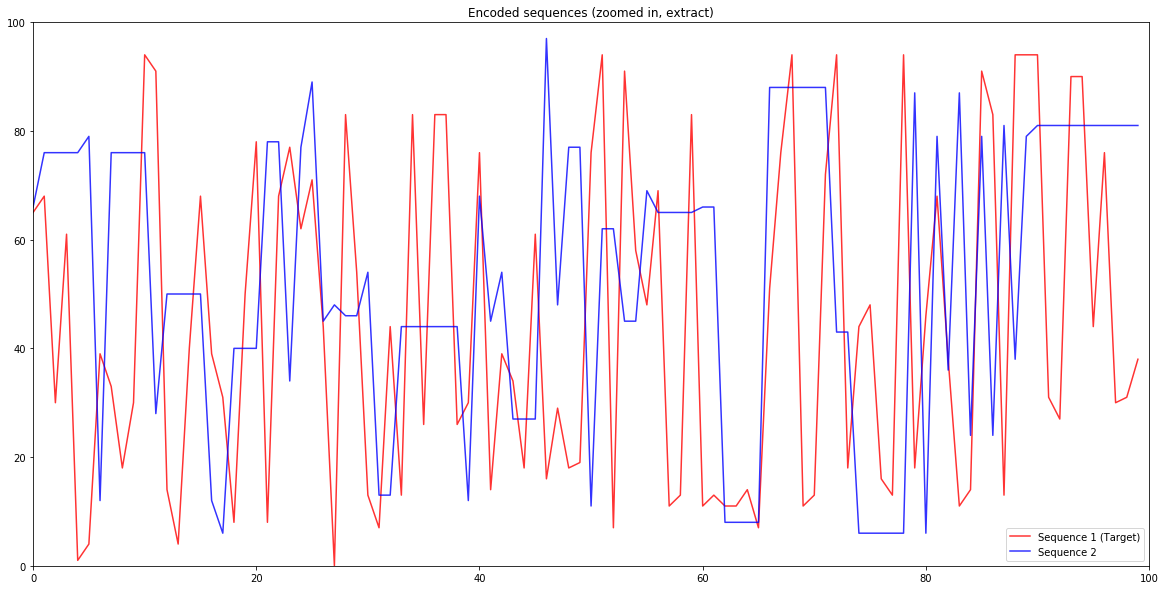

In [8]:
# Plot sequence data
sequence1 = encoded_data[:, 0][:100]
sequence2 = encoded_data[:, 1][:100]

plt.figure(figsize=(20, 10))

plt.plot(range(len(sequence1)), sequence1, color='red', label='Sequence 1 (Target)', alpha=0.8)
plt.plot(range(len(sequence2)), sequence2, color='blue', label='Sequence 2', alpha=0.8)

plt.legend(frameon=True)
plt.title('Encoded sequences (zoomed in, extract)')
plt.axis([0, max(len(sequence1), len(sequence2)), 0, num_classes])

plt.show()

In [9]:
def generator(data, seq_len, min_index, max_index):
    i = min_index
    while 1:
        if i + batch_size >= max_index:
            i = min_index
        rows = np.arange(i, min(i + batch_size, max_index))
        i += len(rows)
        samples = np.zeros((len(rows), seq_len), dtype='int32')
        targets = np.zeros((len(rows)), dtype='int32')
        for j, _ in enumerate(rows):
            indices = range(rows[j], rows[j] + seq_len)
            if indices[-1] < max_index:
                targets[j] = data[:, 0][indices][-1]
                samples[j] = data[:, 1][indices]
        yield samples, targets

In [10]:
# Split in 3 sets for training, validation and testing
validation_steps = round((data_split / 2) * len(data))

train_max = len(data) - (validation_steps * 2)
val_min = train_max + 1
val_max = train_max + validation_steps + 1
test_min = train_max + validation_steps + 2
test_max = len(data) - 1

training_steps = test_max - test_min

train_gen = generator(encoded_data,
                      seq_len=seq_len,
                      min_index=0,
                      max_index=train_max)

val_gen = generator(encoded_data,
                    seq_len=seq_len,
                    min_index=val_min,
                    max_index=val_max)

test_gen = generator(encoded_data,
                     seq_len=seq_len,
                     min_index=test_min,
                     max_index=test_max)

steps_per_epoch = train_max // batch_size

print('Batch size:', batch_size)
print('Steps per epoch:', steps_per_epoch)

print('\nSplit for validation & test @ {0:.2f}%'.format(data_split * 100))
print('Training set:', (0, train_max))
print('Validation set:', (val_min, val_max))
print('Test set:', (test_min, test_max))

Batch size: 32
Steps per epoch: 49

Split for validation & test @ 10.00%
Training set: (0, 1594)
Validation set: (1595, 1684)
Test set: (1685, 1771)


In [11]:
model = Sequential()
model.add(layers.Embedding(input_dim=num_classes,
                           output_dim=num_units,
                           input_length=seq_len))
for n in range(num_layers - 1):
    model.add(layers.LSTM(num_units, return_sequences=True))
    if dropout > 0.0:
        model.add(layers.Dropout(dropout))
model.add(layers.LSTM(num_units))
if dropout > 0.0:
    model.add(layers.Dropout(dropout))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3, 128)            12800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               12900     
Total params: 157,284
Trainable params: 157,284
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit_generator(train_gen,
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=val_gen,
                              validation_steps=validation_steps)

Epoch 1/50
49/49 [==============================] - 2s 34ms/step - loss: 4.5821 - acc: 0.0242 - val_loss: 4.4893 - val_acc: 0.0471
Epoch 2/50
49/49 [==============================] - 1s 16ms/step - loss: 4.3297 - acc: 0.0408 - val_loss: 3.9268 - val_acc: 0.0000e+00
Epoch 3/50
49/49 [==============================] - 1s 14ms/step - loss: 4.1492 - acc: 0.0408 - val_loss: 3.9712 - val_acc: 0.0000e+00
Epoch 4/50
49/49 [==============================] - 1s 13ms/step - loss: 4.1194 - acc: 0.0453 - val_loss: 3.9868 - val_acc: 0.0000e+00
Epoch 5/50
49/49 [==============================] - 1s 13ms/step - loss: 4.0878 - acc: 0.0402 - val_loss: 4.0180 - val_acc: 0.0154
Epoch 6/50
49/49 [==============================] - 1s 13ms/step - loss: 4.0551 - acc: 0.0529 - val_loss: 4.0477 - val_acc: 0.0000e+00
Epoch 7/50
49/49 [==============================] - 1s 14ms/step - loss: 3.9972 - acc: 0.0682 - val_loss: 4.1038 - val_acc: 0.0000e+00
Epoch 8/50
49/49 [==============================] - 1s 14ms/ste

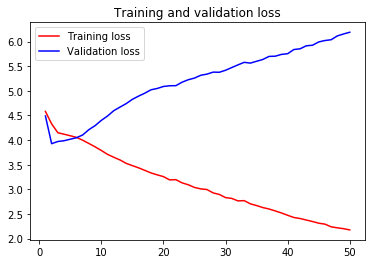

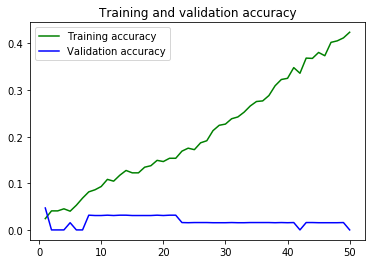

In [13]:
# Plot validation and training loss
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [20]:
# Calculate scores with training set
temperature = 1           # Temperature for reweighting the distribution
max_dist = .25            # Maximum distance for max. score penalty

def reweight_distribution(original_distribution, temperature):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)

scores = []
points = []
points_targets = []

for i in range((training_steps // batch_size)):
    # Predict point from model
    samples, targets = next(train_gen)
    results = model.predict(samples)

    for j, result in enumerate(results):
        # Reweight the softmax distribution
        result_reweighted = reweight_distribution(result, temperature)
        result_value = np.argmax(result_reweighted)
        
        # Decode data
        position = k_means_decode_data([[result_value]], kmeans).flatten()
        position_target = k_means_decode_data([[targets[j]]], kmeans).flatten()
        points.append(position)
        points_targets.append(position_target)

        # Calculate distance between prediction and actual test target
        dist = max_dist - min(max_dist, np.linalg.norm(position - position_target))
        dist = 0.0 if dist == 0.0 else dist / max_dist
        scores.append(dist)
        
        print('sequence: {0}, expected: {1}, result: {2}, score: {3:.2f}%'.format(
            samples[j],
            targets[j],
            result_value,
            dist * 100))
        
points = np.array(points)
points_targets = np.array(points_targets)
score = np.average(scores)

print('\nScore: {0:.2f}%'.format(score * 100))

sequence: [92 92 92], expected: 19, result: 36, score: 33.00%
sequence: [92 92 87], expected: 27, result: 27, score: 100.00%
sequence: [92 87 87], expected: 46, result: 46, score: 100.00%
sequence: [87 87 76], expected: 18, result: 18, score: 100.00%
sequence: [87 76 76], expected: 13, result: 13, score: 100.00%
sequence: [76 76 76], expected: 83, result: 11, score: 79.66%
sequence: [76 76 31], expected: 50, result: 50, score: 100.00%
sequence: [76 31 72], expected: 4, result: 4, score: 100.00%
sequence: [31 72 91], expected: 62, result: 62, score: 100.00%
sequence: [72 91 91], expected: 85, result: 85, score: 100.00%
sequence: [91 91 16], expected: 46, result: 0, score: 52.48%
sequence: [91 16 79], expected: 31, result: 31, score: 100.00%
sequence: [16 79 64], expected: 12, result: 12, score: 100.00%
sequence: [79 64 64], expected: 36, result: 36, score: 100.00%
sequence: [64 64 97], expected: 90, result: 90, score: 100.00%
sequence: [64 97 97], expected: 85, result: 85, score: 100.00

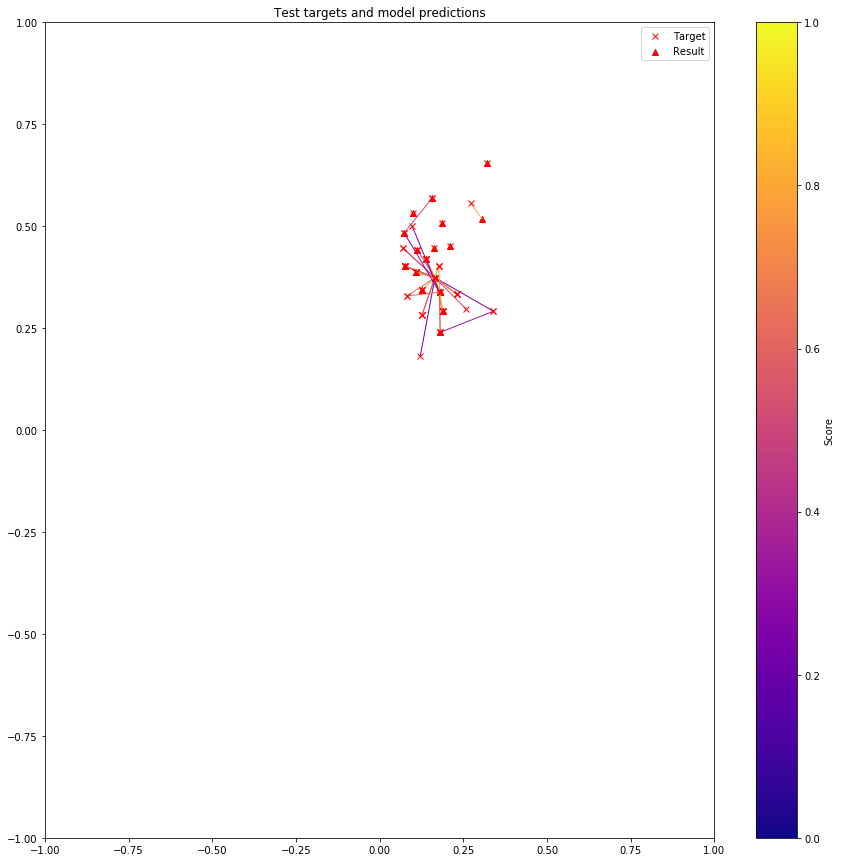

In [21]:
# Plot model prediction results
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title('Test targets and model predictions')
ax.axis([-1.0, 1.0, -1.0, 1.0])

lines = [[points_targets[i], points[i]] for i in range(len(points))]
lc = mc.LineCollection(lines, linewidths=1)
lc.set_array(np.array(scores))
lc.set_clim(0.0, 1.0)
lc.set_cmap('plasma')
ax.add_collection(lc)

axcb = fig.colorbar(lc)
axcb.set_label('Score')

ax.plot(points_targets[:,0], points_targets[:,1], 'rx', label='Target')

colors = np.array([[s, 0, 0] for s in scores])
ax.scatter(points[:,0], points[:,1], label='Result', color='r', marker='^')

ax.legend()
plt.show()